In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys

import numpy as np
import scipy as sp
import h5py as h5

import csi.gp          as gp
import csi.postprocess as pp

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
mod = pp.csi_mod("./dream-trunc3.h5")
res = []
for i in range(10):
    r = pp.csi_res(mod,i)
    r.sort_psets()
    res.append(r)

In [25]:
dataset = 2
ds = [d for i,d in enumerate(mod.data) if i != dataset]
pred = [pp.csi_pred(r,r.psets[0].tolist()) for r in res]

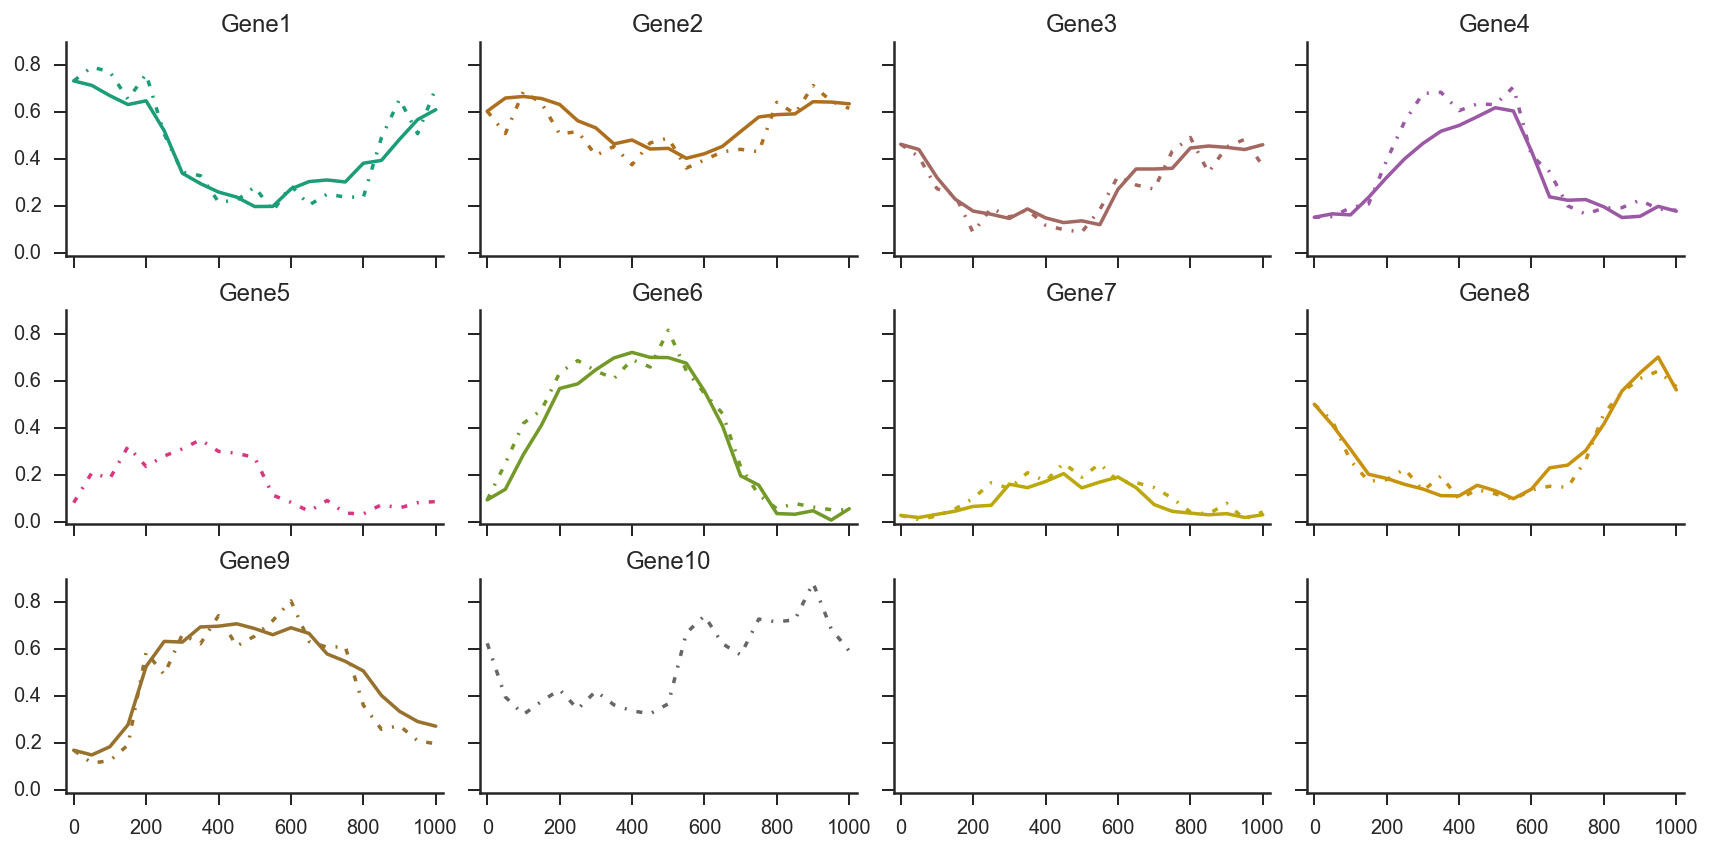

In [26]:
# 4 and 9 difficult
given = [4,9]

# generate predicted expression
out = sp.rand(21,10)
out[:,given] = mod.data[dataset].T[:,given]
out[0,:] = mod.data[dataset].T[0,:]
for i in range(1,len(out)):
        for j in range(10):
            if j in given:
                continue
            mu,var = pred[j].predict1(out[i-1,:])
            out[i,j] = mu[0] + sp.randn() * np.sqrt(var[0,0])

# and plot
with sns.axes_style("ticks"):
    fig,axs = plt.subplots(3,4,figsize=(12,6),sharex=True,sharey=True)

pal = plt.get_cmap('Dark2')(np.linspace(0,1,10))

for i,ax in zip(range(10),axs.flatten()):
    ax.margins(0.02)
    ax.set_title(mod.items[i])
    if i not in given:
        ax.plot(mod.time[dataset],out[:,i],color=pal[i])
    ax.plot(mod.time[dataset], mod.data[dataset].T[:,i],'-.',color=pal[i]);

sns.despine()
fig.tight_layout()